In [149]:
from pathlib import Path
from scipy.io import mmread
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

WORKSPACE_ROOT = Path("../../").resolve()

In [150]:
data_dir = WORKSPACE_ROOT / "data/pbmc_vir/processed_data_files"
todo = ["HCMV1", "HCMV2", "mock1", "mock2"]

sample_bars = {}
sample_genes = {}
for sample_name in todo:
    df_gene = pd.read_csv(data_dir/f"{sample_name}-features.tsv", sep="\t", header=None)
    df_gene = df_gene.iloc[:, 0:2]
    df_gene.columns = ["locus", "gene"]
    sample_genes[sample_name] = df_gene

    df_bar = pd.read_csv(data_dir/f"{sample_name}-barcodes.tsv", sep="\t", header=None)
    df_bar = df_bar.iloc[:, 0:1]
    df_bar.columns = ["barcode"]
    sample_bars[sample_name] = df_bar

def make_index_map(df):
    x2i = pd.DataFrame(df)
    x2i.set_index("locus", inplace=True)
    x2i["ival"] = np.arange(len(df))
    return x2i

_dfs = list(sample_genes.values())
df_allg = pd.DataFrame(_dfs[0])
for _df in _dfs[1:]:
    df_allg = pd.merge(df_allg, _df, how="outer", on="locus")
    df_allg["gene_x"].fillna(df_allg["gene_y"], inplace=True)
    df_allg.columns = [c.replace("_x", "") for c in df_allg.columns]
    df_allg = df_allg[["locus", "gene"]]

mats = {}
for sample_name in todo:
    sample = mmread(data_dir/f"{sample_name}-matrix.mtx").T
    genes = sample_genes[sample_name]
    sample_len = sample.shape[0]

    g2i = make_index_map(genes)
    all_genes_f = df_allg[df_allg["locus"].isin(genes["locus"])].locus
    new_gene_order = g2i.loc[all_genes_f].ival.to_numpy(dtype=np.int32)

    sample = sample.tocsr()[:, new_gene_order]
    sample.resize((sample_len, df_allg.shape[0]))
    df_obs = sample_bars[sample_name]
    df_obs["barcode"] = f"{sample_name}-"+df_obs["barcode"]
    mats[sample_name] = sc.AnnData(sample, obs=df_obs)

In [151]:
adata = ad.concat(mats, label="sample")
adata.var = df_allg
adata.obs.columns = ["barcode", "sample"]
print(adata.X.shape)
print(adata.obs["sample"].value_counts())

(25312, 36601)
sample
HCMV1    7460
mock1    7385
HCMV2    5321
mock2    5146
Name: count, dtype: int64


In [152]:
print(adata.var.shape)
adata.var.head(3)

(36601, 2)


,locus,gene
0,ENSG00000000003,TSPAN6
1,ENSG00000000005,TNMD
2,ENSG00000000419,DPM1


In [153]:
print(adata.obs.shape)
adata.obs.head(3)

(25312, 2)


,barcode,sample
0,HCMV1-AAACCCAAGCCTGACC-1,HCMV1
1,HCMV1-AAACCCAAGGCAATGC-1,HCMV1
2,HCMV1-AAACCCAAGGGTCACA-1,HCMV1


In [154]:
sc.pp.calculate_qc_metrics(
    adata, inplace=True, log1p=True
)
adata

AnnData object with n_obs × n_vars = 25312 × 36601
    obs: 'barcode', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'locus', 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

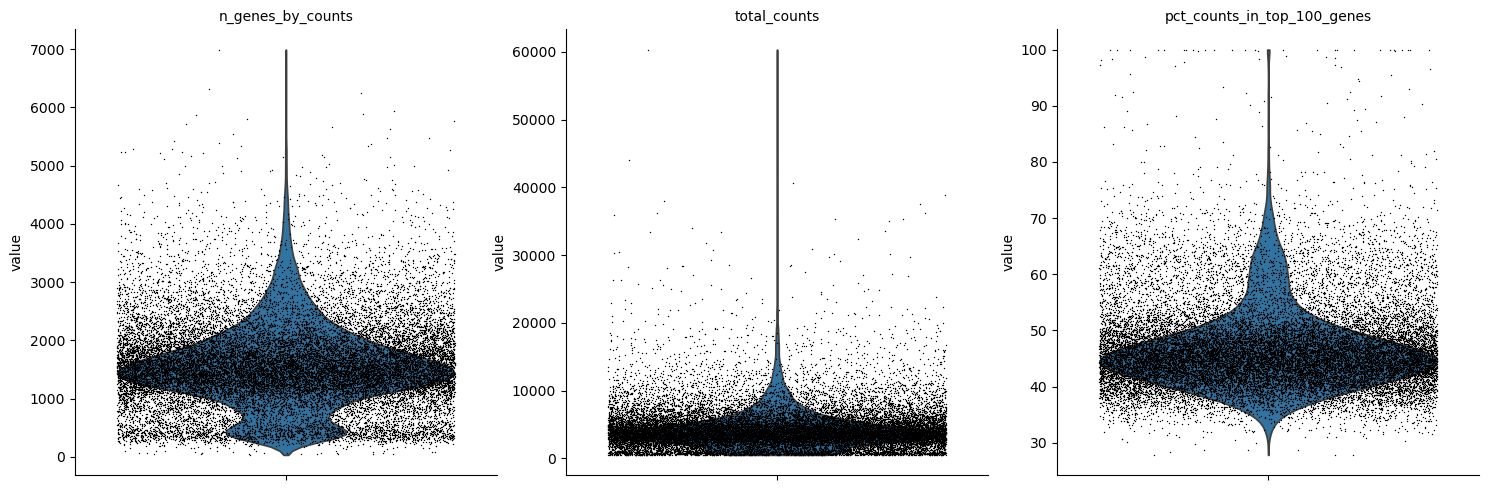

In [155]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_in_top_100_genes"],
    jitter=0.4,
    multi_panel=True,
)

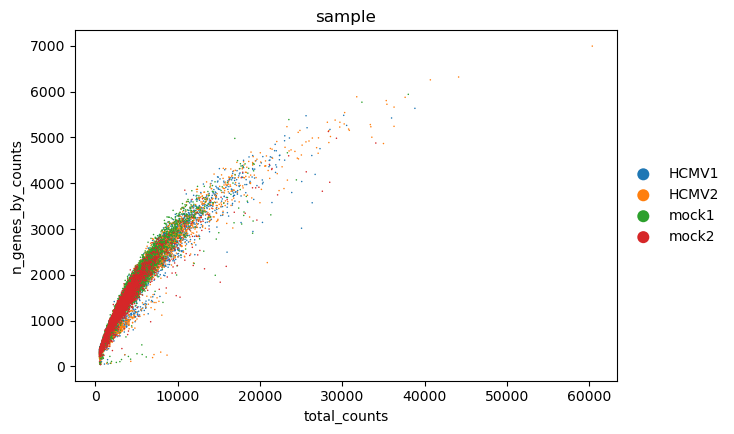

In [156]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="sample")

In [157]:
# separate into infected and control?

# normalize

# ctap
# https://github.com/bowang-lab/scGPT

# look at proportions of cell types
# look at expression differences within each cell type